In [1]:
import svgling
from svgling.figure import SideBySide, RowByRow, Caption
# two sample trees
t0 = ("S", ("NP", "D", "N"), ("VP", "V", ("NP", "D", "A", "N")))
t1 = ("S", ("NP", ("D", "the"), ("N", "rhinoceros")), ("VP", ("V", "saw"), ("NP", ("D", "the"), ("A", "gray"), ("N", "elephant"))))
demo_trees = [t0, t1]

# Guide to the `svgling` package

The `svgling` package is a python tree-drawing package, aimed at linguists who want to draw constituent trees. It is tailored specifically towards rendering trees in Jupyter, but could be used for programmatically generating SVG tree diagrams in general.

* [1. Interface overview](#1.-Interface-overview)
   - [SVG formatting](SVG-formatting)
   - [Nodes and constituents](Nodes-and-constituents)
* [2. Layout and display options](#2.-Layout-and-display-options)
   - [Layout overview](#Layout-overview)
   - [Debug mode](#Debug-mode)
   - [Overall layout options](#Overall-layout-options)
   - [Line and node positioning options](#Line-and-node-positioning-options)
   - [Text options](#Text-options)
* [3. Tree annotations](#3.-Tree-annotations)
   - [Annotating constituents](#Annotating-constituents)
   - [Movement arrows](#Movement-arrows)
* [4. Complex figures](#4.-Complex-figures)

## 1. Interface overview

The main interface to `svgling` is `svgling.draw_tree`. This function takes a tree description, and named arguments specifying options. The valid options are described below, and options parameters are used to construct a `svgling.core.TreeOptions` object; such an object can be passed directly and passed via a named argument `options`. The default options can be accessed via `svgling.core.TreeOptions()`.

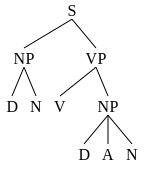

In [2]:
svgling.draw_tree(t0)

The tree description can be in one of two forms: an indexable object (e.g. list, tuple) consisting of a head at index 0 and a possibly empty sequence of subtrees at indices $1..n$, or an object implementing the `nltk.Tree` api, which stores the head label in the function `.label()` and the daughter subtrees as indices on the object. See `t0` and `t1` above for examples of the indexable format, but this is pretty standard notation going back to lisp.

The package also will monkey-patch `nltk` if it's available, adding the function `nltk.Tree._repr_svg_()` that calls `draw_tree(self)` behind the scenes. To adjust options for nltk trees, you can set values on `svgling.core.nltk_tree_options`, which is a `nltk.core.TreeOptions` instance. If you want to go further, `svgling.disable_nltk_png()` will completely remove the default `nltk` tree-drawing code, preventing it from ever being called. (Jupyter will typically try every `_repr_*_` call and store the results in a notebook file, even though it has a preference which to show.)

### SVG formatting

Many options through this document interact with SVG formatting, via arguments pass to the `svgwrite` API. I won't specify the details of this here, see the `svgwrite` docs for details. Generally, `svgwrite` formatting parameters are validated and passed transparently through to svg itself with the python `_` character turned into `-`, so for details of how svgwrite parameters are interpreted, also see the SVG specification (and whatever viewer-specific documentation there is - not all SVG renderers are alike). I have generally not passed through all parameters, but rather chosen a few that I think are the most useful. Two key parameters that show up repeatedly for lines are `stroke` (which gets filled in with a color or `none`) and `stroke_width` (which gets filled in with a measurement, usually in *px*, e.g. `1px`).

**Units**: SVG uses CSS-style units, which can be a little confusing. Here's a quick reference primer on the ones that will come up in this manual.
* `em`: the height of one line of text, at the current font size, from baseline to baseline.
* `px`: stands for "pixel", but does not necessarily correspond literally to a pixel in CSS; the interpretation is more abstract. The increment `1px` corresponds to an optical reference unit that is the smallest object likely to be visible on a screen. Some but not all displays can render objects that are less than `1px`.
* `%`: percentage of the immediately containing SVG box.
* `pt`: a unit inherited from print typography, but again in CSS this is interpreted kind of abstractly and won't really correspond to any reliable physical distance (what you might expect from the history). Not recommended for screen-oriented rendering. For css and svg, `1pt = 0.75px` (so `12pt = 16px`, for the most useful special case).

### Nodes and constituents

**Nodes**: A tree node is (for now) just a string. This string may span multiple lines, which are separated by `\n`. For example: `"N\ncat"` gives a two-line node with `N` as the first like and `cat` as the second. Within a node, multiple lines are anchored at the middle (leading to centering). A label consisting of the empty string `""` is considered empty, and will not render at all -- the lines will be joined in the middle of the row height. If you want a blank label, any sequence of whitespace will work, e.g. `" "`.

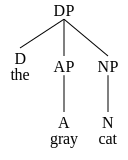

In [3]:
svgling.draw_tree("DP", "D\nthe", ("AP", "A\ngray"), ("NP", "N\ncat"))

**Selecting nodes and constituents**: For various purposes discussed throughout this manual, you can select particular parts of a tree (usually nodes or constituents) for formatting. To do this, you use what is sometimes called a **tree path**. These are sequences of indices that traverse the tree from the root node by choosing a daughter in left-to-right order. Indices begin at 0.

So for example, the path `(0,1,1)` gives the second daughter of the second daughter of the first daughter of the root node. The empty path `()` gives the subtree headed at the root. As this example illustrates, a path needn't be complete, and for annotation purposes will typically be interpreted as selecting an entire constituent, though for some purposes it may select a node. As a reminder, a length 1 path written as a tuple will require a comma so that python can disambiguate it from just a regular number in parenthesis, e.g. `(0,)`. A path that selects a daughter node whose index is greater than the number of daughters at that point in the tree is invalid. Using negative indices is possible, and these will be interpreted like negative indices in python: e.g. `-1` selects the rightmost node, etc.

The following diagram illustrates some example valid tree paths as python tuples.

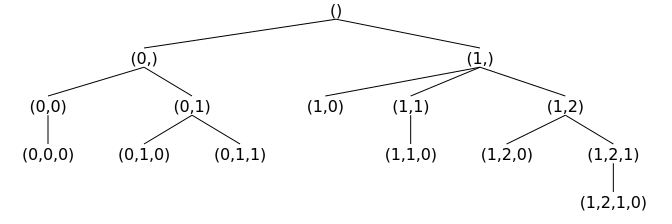

In [4]:
svgling.draw_tree(("()", ("(0,)", ("(0,0)", "(0,0,0)"), ("(0,1)", "(0,1,0)", "(0,1,1)")),
                         ("(1,)", "(1,0)", ("(1,1)", "(1,1,0)"), ("(1,2)", "(1,2,0)", ("(1,2,1)", "(1,2,1,0)")))),
                 global_font_style=svgling.core.MONO, average_glyph_width=1.5)

Relative to the above tree, the paths `(2,)` and `(1,0,0)` would (for example) be invalid. The paths `(-1,-1,-1)` and `(-1,2,-2)` (for example) would select the subtree identified by `(1,2,1)` and `(1,2,0)` respectively.

## 2. Layout and display options

The customizable `TreeOptions` parameters are described in the rest of this section.

### Layout overview

**Vertical layout**: A node at depth $n$ (where the root node of the tree is depth $0$) is positioned vertically in a line with all other nodes of depth $n$. Exception (see below for examples): if `leaf_nodes_align` is set to true, any leaf nodes are aligned with the lowest level of the tree, rather than depth they would otherwise be at. Within a row, vertical space is allowed for the tallest node at that depth; positioning of shorter nodes at that depth is configurable. Vertical spacing is calculated/generated in *em*s.

**Horizontal layout**: The horizontal position of daughter nodes relative to a parent is determined by a (configurable) algorithm, usually based on some measure of the size of the daughter nodes. By default, this algorithm estimates the max text width taken up by the parent node label or the width of daughter nodes (and their daughters, etc). See below for examples of other options. No node will be positioned vertically below a node that does not dominate it. There is also a configurable padding parameter. Horizontal spacing is calculated initially in estimated *em*s, but (canvas width aside) is converted to percentages for svg layout. Because `svgling` does not do multi-pass rendering, it uses heuristics for glyph width rather than accurately calculating glyph width. (To do this, you'd basically need to render to a device, and see what happens.)

**Canvas layout**: The canvas width is estimated from node text width + padding. The canvas height is determined by the tree depth, level heights, with an extra 1em at the bottom of the canvas for descenders from leaf node glyphs.

### Debug mode

**`debug`**: When this option is set to `True`, the rendered will show a `1em` grid, as well as a red box for every subtree. This can be useful if something isn't doing what you expect. Several of the documentation examples below use this to illustrate various spacing options.

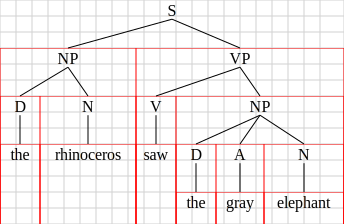

In [5]:
svgling.draw_tree(t1, debug=True)

### Overall layout options

The following are `TreeOptions` parameters that affect layout.

**`horiz_spacing`**: This parameter determines how daughter nodes are spaced horizontally relative to the parent. Possible values are `svgling.core.HorizSpacing.TEXT` (default; space proportionally based on estimated text width), `svgling.core.HorizSpacing.EVEN` (space evenly based on number of immediate daughters), and `svgling.core.HorizSpacing.NODES` (space proportionally to the number of leaf nodes in the subtrees).

Usually `TEXT` looks best, but the other two may be preferable for abstract trees where label widths are all similar. Without manual adjustment, the two other options will deal poorly with long labels.

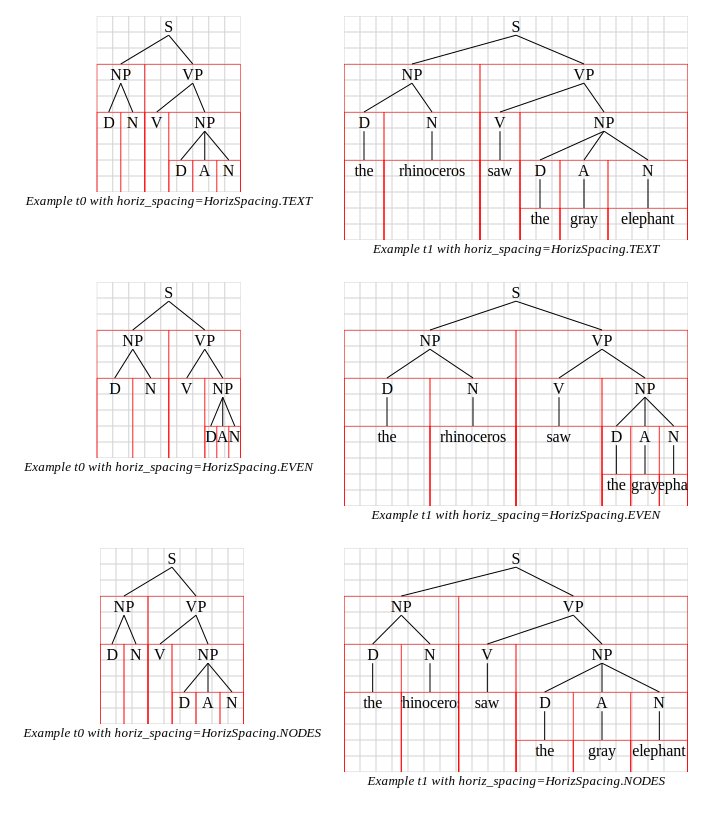

In [6]:
examples = list()
for opt in svgling.core.HorizSpacing:
    row = list()
    for t in range(len(demo_trees)):
        # debug mode on so that the exact rendering differences are very obvious
        row.append(Caption(svgling.draw_tree(demo_trees[t], horiz_spacing=opt, debug=True), "Example t%d with horiz_spacing=%s" % (t, str(opt))))
    examples.append(SideBySide(*row))

RowByRow(*examples)

**`average_glyph_width`**: A heuristic factor used to calculate text widths; basically, a divisor in *em*s. Defaults to `2.0`. Does not generally need to be adjusted for default settings (which try to just use Times), but may be worth adjusting for custom fonts.

**`leaf_padding`**: An amount to pad each leaf by, in glyphs. Will be divided by `average_glyph_width`. Default is 2. Negative values are possible, but will usually result in text being cut off. Leaf padding is applied as a constant to the overall canvas size regardless of the value of `horiz_spacing` (i.e. the canvas size is always determined by the sum of node widths plus leaf padding at every widest subtree), so will impact spacing to some degree for any setting of this option, but is only applied directly to each leaf for `HorizSpacing.TEXT`.

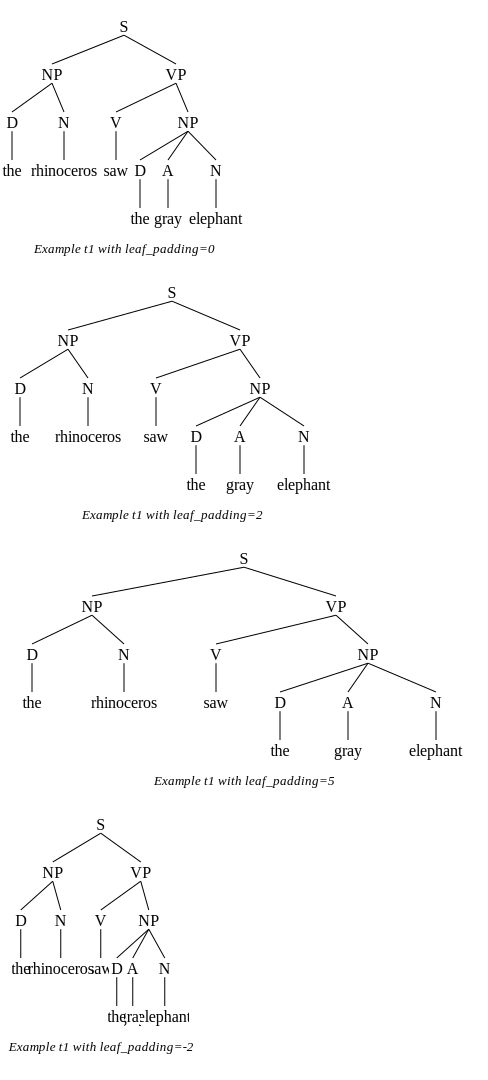

In [7]:
examples = list()
for i in (0, 2, 5, -2):
    examples.append(Caption(svgling.draw_tree(t1, leaf_padding=i), "Example t1 with leaf_padding=%g" % i))
RowByRow(*examples)

**`vert_align`**: How row alignment when there are multi-line labels should be calculated. If all labels in a row have the same height, this has no impact, but if there are differences, it controls the position of the shorter node labels vertically. Default is centered. For empty labels, this affects the position of the line join. The values `TOP`, `CENTER`, and `BOTTOM` are self-explanatory. `svgling.VertAlign.EVEN` causes all nodes to be treated as the same height (relative to their row) regardless of text contents, even empty nodes.

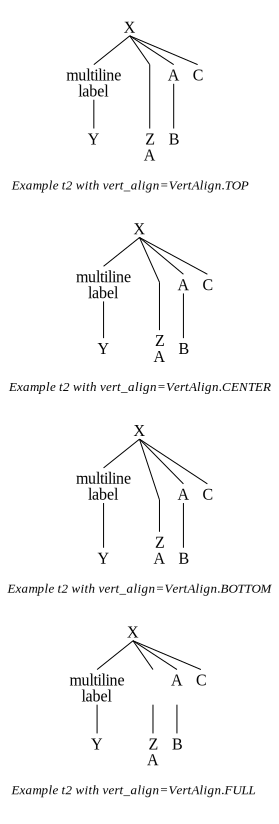

In [8]:
t2 = ("X", ("multiline\nlabel", "Y"), ("", "Z\nA"), ("A", "B"), "C")

examples = list()
for opt in svgling.core.VertAlign:
    examples.append(Caption(svgling.draw_tree(t2, vert_align=opt), "Example t2 with vert_align=%s" % str(opt)))

RowByRow(*examples)

**`distance_to_daughter`**: The distance between rows in *em*s -- that is, distance from the bottom of one row to the top of another. Values less than about 0.5 are not recommended and will usually result in rendering oddities. Note that line starts are 0.2*em*s below a node label, so 0.2 will give completely horizontal lines (not 0.0).

Default is 2.

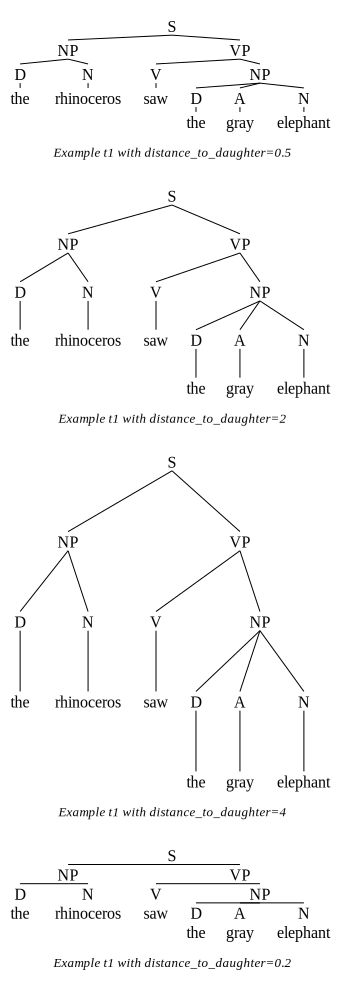

In [9]:
examples = list()
for i in (0.5, 2, 4, 0.2):
    examples.append(Caption(svgling.draw_tree(t1, distance_to_daughter=i), "Example t1 with distance_to_daughter=%g" % i))
RowByRow(*examples)

### Line and node positioning options

**`leaf_nodes_align`**: if true, will align all leaf nodes with the lowest depth leaf nodes in the tree.

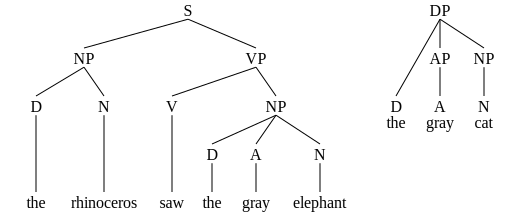

In [10]:
SideBySide(svgling.draw_tree(t1, leaf_nodes_align=True), svgling.draw_tree("DP", "D\nthe", ("AP", "A\ngray"), ("NP", "N\ncat"), leaf_nodes_align=True))

**`descend_direct`**: When an edge skips levels (currently only possible for leaf nodes, when `leaf_nodes_align=True`), should the line go directly from the parent to the daughter? If `False`, the line will go to the position that the daughter would have been at as if there is an empty node there, and descend vertically. This can be useful for very deep trees where a `True` value results in overlapping, and also just look better. However, it doesn't allow distinguishing empty nodes visually in the tree. As with empty nodes, the positioning of the line join is affected by `vert_align`. Defaults to `True`.

The following example shows a tree that renders quite badly without this option set to `True`, because of the asymmetry between leaf node widths.

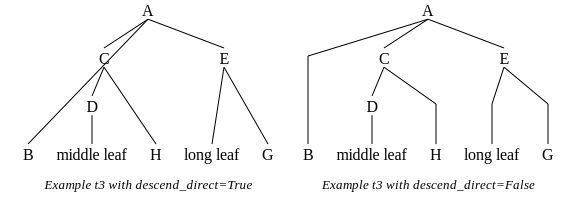

In [11]:
t3 = ("A", "B", ("C", ("D", "middle leaf"), "H"), ("E", "long leaf", "G"))
examples = list()
for opt in (True, False):
    examples.append(Caption(svgling.draw_tree(t3, leaf_nodes_align=True, descend_direct=opt), "Example t3 with descend_direct=%s" % str(opt)))
SideBySide(*examples)

### Edge styles

Custom styles can be applied to specific edges. The main application for this is drawing so-called "triangles of laziness", but it does also allow you to change the color of particular edges and other related things. There is currently no way to change the edge styles for a tree as a whole (I'll implement such a thing if there's demand for it). Be aware that non-direct descents are implemented as an edge style, so if you apply a style to a leaf node with `leaf_nodes_align=True`, then it can override the indirect descent style; use the `IndirectDescent` class to avoid this.

There are three classes that encapsulate edge styles:
* `svgling.core.EdgeStyle` is the default edge style. It allows two svg parameters: `stroke` and `stroke_width`.
* `svgling.core.IndirectDescent` implements indirect descents for nodes that skip levels. It inherits the svg parameters of `EdgeStyle`.
* `svgling.core.TriangleEdge` draws a triangle with points at the center of the parent, and the left and right bounds of the daughter text. (Note that, as usual, text width is calculated heuristically.) This class also inherits the svg parameters of `EdgeStyle`.

To set an edge style, call `set_edge_style` on the layout object with a path and one of the above objects.

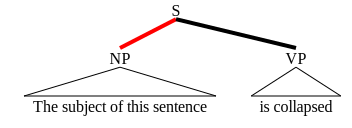

In [12]:
t5 = ("S", ("NP", "The subject of this sentence"), ("VP", "is collapsed"))
out = svgling.draw_tree(t5)
out.set_edge_style((0,0), svgling.core.TriangleEdge())
out.set_edge_style((1,0), svgling.core.TriangleEdge())
# now for some gratuitous formatting
out.set_edge_style((0,), svgling.core.EdgeStyle(stroke_width="4px", stroke="red"))
out.set_edge_style((1,), svgling.core.EdgeStyle(stroke_width="4px"))
out

### Text options

**`global_font_style`**: a css-formatted string that will be used to style text in the tree. Since this is css, you can put all sorts of stuff in it, but I recommend at least including `font-family`, `font-weight`, and `font-style`, because without these font rendering may be inconsistent depending on where the svg is embedded (for example showing as serif in some settings, sans-serif in others). If you are sharing your svg with others, I recommend sticking to web-safe fonts. The default values is: `"font-family: times, serif; font-weight:normal; font-style: normal;"`. You cannot set font size this way.

**`font_size`**: a numeric value, to be interpreted in `px`, for the font size. The default is `16` (which corresponds to `12pt`).

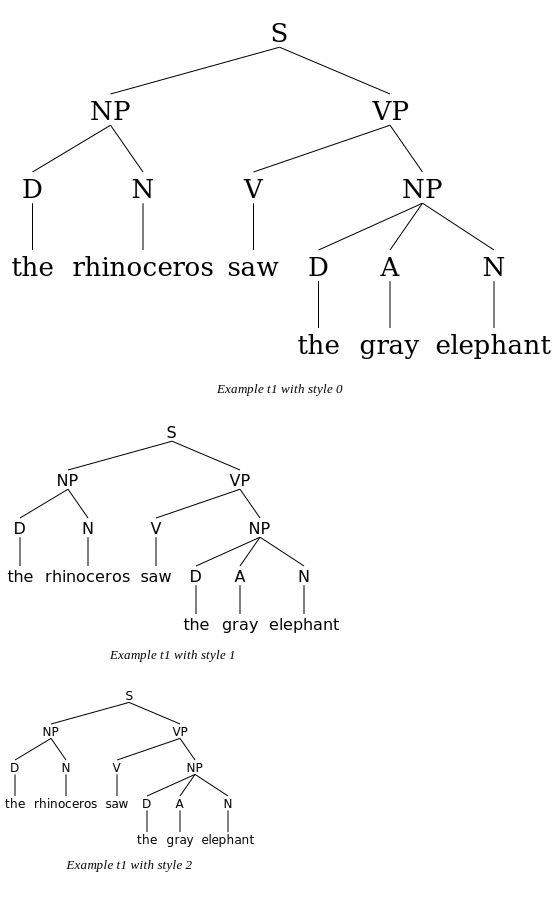

In [13]:
t1 = ("S", ("NP", ("D", "the"), ("N", "rhinoceros")), ("VP", ("V", "saw"), ("NP", ("D", "the"), ("A", "gray"), ("N", "elephant"))))
styles = (("font-family: georgia, times, serif; font-weight:normal; font-style: normal;", 26),
          ("font-family: sans-serif; font-weight:normal; font-style: normal;", 16),
          ("font-family: impact, times, serif; font-weight:normal; font-style: italic;", 12))

examples = list()
for i in range(len(styles)):
    examples.append(Caption(svgling.draw_tree(t1, global_font_style=styles[i][0], font_size=styles[i][1]), "Example t1 with style %d" % i))
RowByRow(*examples)

## 3. Tree annotations

The `draw_tree` function returns a `TreeLayout` object which can be further manipulated by adding what are called annotations. These are extra graphics that overlay on the tree, and typically interact with the tree's structure. These annotations make heavy use of **tree paths**, discussed in section 1.

### Annotating constituents

If you want to highlight a specific constituent, you can draw a box around it, and/or underline it.

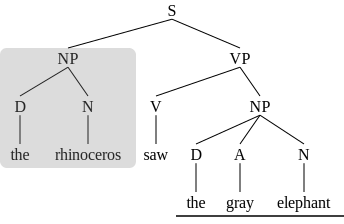

In [14]:
out = svgling.draw_tree(t1)
out.box_constituent((0,))
out.underline_constituent((1,1))
out

Both of these functions accept a number of extra svg arguments determining the details of the annotation. For `box_constituent`, you can pass `stroke`, `stroke_width`, `fill`, `fill_opacity`, and `rounding`. For `underline_constituent` you can pass `stroke`, `stroke_width`, and `stroke_opacity`. As can be seen above, boxes default to light non-opaque gray with rounded edges, and no stroke.

### Movement arrows

Movement arrows can be drawn between arbitrary constituents; `svgling` will attempt to keep them from overlapping with each other or with the tree. The arrow always starts below the center of the first constituent, descends, moves horizontally, and attaches vertically to the center of the second constituent. It can be convenient to combine arrows with some kind of constituent-grouping annotation, for complex constituents. The following example illustrates movement arrows in a typical case of Quantifier Raising.

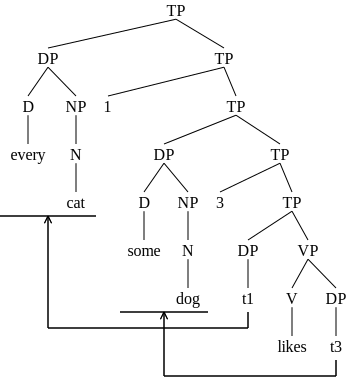

In [15]:
t2 = ("TP", ("DP", ("D", "every"), ("NP", ("N", "cat"))),
           ("TP", "1", ("TP", ("DP", ("D", "some"), ("NP", ("N", "dog"))),
                     ("TP", "3", ("TP", ("DP", "t1"), ("VP", ("V", "likes"), ("DP", "t3")))))))
out = svgling.draw_tree(t2)
out.movement_arrow((1,1,1,1,0), (0,))
out.underline_constituent((0,))
out.movement_arrow((1,1,1,1,1,1), (1,1,0), stroke_width="1px", stroke="black")
out.underline_constituent((1,1,0))
out

## 4. Complex figures

As several of the above examples illustrate, `svgling.figure` provides facilities for generating more complex figures out of svg drawings. These classes are still rather basic, and they don't do well for really arbitrary figures, but they do well enough for combining `svgling` trees together. In principle, they work on any object that implements the following functions:

 * `get_svg()`: return an `svgwrite` object.
 * `height()`: get the diagram height *in px*.
 * `width()`: get the diagram width *in px*.

All the classes described here implement this interface, and so may be combined. See the above text for examples of all three of these classes.

**`Caption`**: This places a text caption below an svg drawing. Construct with `Caption(fig, text)`.

**`SideBySide`**: This places a list of svg drawings in a row. Construct with `SideBySide(fig1, fig2, ..., fign, padding=x)`, where `padding` gives a padding in pixels to be applied between subfigures and in the left and right margin.

**`RowByRow`**: This places a list of svg drawings in a column. Construct with `RowByRow(fig1, fig2, ..., fign, padding=x)`, where `padding` gives a padding pixels to be applied between subfigures and in the top and bottom margin. By default, if the rows are themselves `SideBySide` objects, this will adjust the widths so that individual diagrams form a grid. To disable this, pass `gridify=False` to the constructor.